## Overview of project - this is the AWS sagemaker version
This notebook is steps in bold.
1. **Extract text from PDF Resumes**
2. **Use Cosine similarity to match resumes to job postings**
3. **Review Scoring with Data Visualizations and comparisons**

In [39]:
import os
import boto3
import re
import sagemaker
import io
import time
import json
import sagemaker.amazon.common as smac

role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket and prefix
bucket = sagemaker.Session().default_bucket()

prefix = 'sagemaker/hireone' # place to upload training files within the bucket

## Step 1. Convert pdf resume to text

In [40]:
#! pip install gensim

In [41]:
# Imports
import re
import string
from collections import Counter

import pandas as pd
import numpy as np
from gensim.summarization import keywords
import matplotlib.pyplot as plt

Download the test pdf resume.

In [42]:
#location link
#'https://raw.githubusercontent.com/AVJdataminer/HireOne/master/data/Binoy_Dutt_Resume.pdf'

In [43]:
#Install pdfminer
#! pip install pdfminer.six

Convert the pdf resume to text strings and print the results.

In [44]:
from pdfminer.high_level import extract_text

#test out reading one pdf file
text = extract_text('data/Binoy_Dutt_Resume.pdf')
text

'Binoy Dutt - https://www.linkedin.com/in/binoydutt \nEmail id: binoydutt@yahoo.com Mobile No.: +1-682-252-8637 https://github.com/binoydutt \n\nEDUCATIONAL  QUALIFICATION: \nMS - Information  Systems (4.0/4.0) \nUniversity of Texas at Arlington, Arlington, TX \n(Business Statistics, OOPS, Data Mining, Data Science, DBMS, Project Management, Systems Analysis and Design, Big Data Analytics, Data Warehouse) \nBS - Chemical Engineering  (3.69/4.0) \n June - 2012 \nNirma University, Gujarat, India \n\nMay  – 2018 \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\nTECHNICAL SKILLS: \nTools:  \n\nLanguages:  \nSkills: \n\nTableau,  Hadoop  Api,  Spark,  Sqoop,  Flume,  Stata,  Weka ,  Hive,  Eclipse  Ide,  SAS,  MS  Project,  MySQL,  Mongodb,  QTP, \nSelenium IDE, Jmeter,  Ms Office, Power BI \nJava, SQL, Python, R \nBusiness Statistical Analysis,  Big Data - Distributed Computing, Data Analysis, Data Visualization, Data Mining, Model \nBuildin

## Step 2. Matching job listings to resumes with cosine similarity
### load the job description data and save to local

In [45]:
df = pd.read_csv('https://raw.githubusercontent.com/AVJdataminer/HireOne/master/data/job_descriptions.csv', encoding = 'unicode_escape')
df.head()

,jobOrResumeDescription,role
0,: Artificial Intelligence / Machine Learning D...,Developer
1,: Data Scientist/Architect\n: 6+ months + Hig...,Data Scientist
2,": Data Analyst\n: Davidson, NC\n: 04+ Months\...",Data Analyst
3,: Big Data Architect or Data Scientist\n: New...,Data Scientist
4,": Data Engineer\n: Woonsocket, RI\n: 6+ Months...",Data Engineer


Clean up job description column.

In [46]:
def clean_text(text):
    text = text.replace('\n', ' ')                # remove newline
    text = text.replace(':', ' ')
    return text
df['description'] = df.apply(lambda x: clean_text(x['jobOrResumeDescription']), axis=1)

Print first job desc

In [47]:
df['description'].iloc[0]

"  Artificial Intelligence / Machine Learning Developer     Irving TX  Terms  Contract   Details             Bachelor's degree or 7-10 or more years of relevant  experience.     7+ years of server app development (design/develop/deploy).     3+ years of Python 3.x, experience in ML algorithms/data analytics.     5+ years of advanced SQL development (ER modeling, SQL scripts, stored procedures, functions, s) with RDBMS such as PostgreSQL/MS SQL Server.     3+ years on AWS S3, EC2, Serverless computing (Lambda).     3+ years of experience/familiarity with DevOps using Stash/Jenkins/Chef and Puppet.     Excellent communication  in interfacing with different cross-functional teams.         5+ years of experience in designing, building applications using .NET platform using C#, .NET Core, ORM, SQL, MS SQL Server, Visual Studio.     1+ years' experience in developing containerized Docker .net core apps."

Create a list from the cleaned job description column

In [48]:
jd = df['description'].tolist()

Build model to tag each job description as a seperate document.


In [49]:
import gensim
import gensim.downloader as api
from gensim import models
# Create the tagged document needed for Doc2Vec
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

train_data = list(create_tagged_document(jd))

print(train_data[:1])

[TaggedDocument(words="  Artificial Intelligence / Machine Learning Developer     Irving TX  Terms  Contract   Details             Bachelor's degree or 7-10 or more years of relevant  experience.     7+ years of server app development (design/develop/deploy).     3+ years of Python 3.x, experience in ML algorithms/data analytics.     5+ years of advanced SQL development (ER modeling, SQL scripts, stored procedures, functions, s) with RDBMS such as PostgreSQL/MS SQL Server.     3+ years on AWS S3, EC2, Serverless computing (Lambda).     3+ years of experience/familiarity with DevOps using Stash/Jenkins/Chef and Puppet.     Excellent communication  in interfacing with different cross-functional teams.         5+ years of experience in designing, building applications using .NET platform using C#, .NET Core, ORM, SQL, MS SQL Server, Visual Studio.     1+ years' experience in developing containerized Docker .net core apps.", tags=[0])]


Train the model on the job descriptions for matching later.

In [50]:
# Init the Doc2Vec model
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

# Build the Volabulary
model.build_vocab(train_data)

# Train the Doc2Vec model
model.train(train_data, total_examples=model.corpus_count, epochs=model.epochs)

In [51]:
model.save("doc2vec.model")

In [52]:
#save to s3 bucket
boto3.Session().resource('s3').Bucket(bucket).Object('doc2vec.model').upload_file('doc2vec.model')

Let's look at an example of how it converts a list of words to a vector.

In [16]:
print(model.infer_vector(['data', 'science','python']))

[ 0.00780979 -0.00644648 -0.00306589  0.00989605  0.00984437  0.00326291
  0.00484538  0.00164365  0.00119862 -0.00875538 -0.00070328  0.00609018
  0.00615306  0.00185711  0.00123987  0.00951959 -0.00200013  0.00508516
 -0.00913142 -0.0087736  -0.00365493  0.00469759 -0.0097369  -0.00736931
  0.00567346  0.00839816  0.00244525  0.00335604  0.00847165 -0.00898291
 -0.00957979 -0.00881275  0.00113318  0.00835414 -0.00266704  0.00292283
  0.00416033  0.00068854  0.00710566  0.00578847  0.00117751 -0.00391402
 -0.00928959  0.00558384 -0.00700451 -0.00558073  0.00560036 -0.00403199
 -0.0016452   0.00123571]


Here we apply the model to each job description in the corpus.

In [53]:
data = []
for i in range(len(jd)):
    data.append(model.docvecs[i])

In [55]:
data[:2]

[array([ 0.42520192, -1.3092649 , -0.04263038,  0.4279058 , -0.10579854,
        -0.97848916,  0.39704782, -0.8654084 ,  1.3791399 ,  0.6703254 ,
        -0.3810882 ,  0.92027277, -0.2372605 , -0.41007313, -1.0953057 ,
        -0.3717445 , -0.18925144,  0.1201918 , -0.37750494, -0.2879344 ,
        -0.32020578,  0.70193315, -1.0198233 , -0.15192962, -0.13900192,
        -1.4699234 ,  0.05974163, -0.9802179 ,  0.1741539 ,  0.26403722,
        -0.01968134, -0.45910412,  0.56507534,  0.6179015 , -0.32542878,
        -0.26430875, -0.16219409, -0.7055974 ,  0.3019703 , -0.6720942 ,
        -0.4591857 , -0.29650146,  0.11393345, -0.46844593,  0.06476261,
         0.33086056, -0.11803669,  0.64546335,  0.220103  , -0.77934384],
       dtype=float32),
 array([ 0.5347606 , -0.29791248, -0.09209407,  0.28679615,  0.3883696 ,
        -0.2507692 ,  0.74912447, -0.2986683 ,  0.8155025 , -0.40040928,
        -0.78248364, -0.04564193, -0.4029797 ,  0.25449017,  0.09985797,
        -0.6713737 ,  0.419

In [56]:
def score_resume(new_doc):

#loading the model
    model="paper.model"
    m=gsm.Doc2Vec.load(model)
print("model is loaded")

	return json.dumps(ret_dict)

## Now let's load the text from our resume

In [18]:
resume = pd.read_csv('https://raw.githubusercontent.com/AVJdataminer/HireOne/master/data/resumes.csv', encoding = 'unicode_escape')
resume.head()

,jobOrResumeDescription,role,sourceType,description
0,Â with around 5 years of experience in all p...,Data Scientist,resume,Â with around 5 years of experience in all p...
1,\n \nData scientist with a strong math backgro...,Data Scientist,resume,Data scientist with a strong math backgroun...
2,\n\n\n* Around 4+ years of experience in Data...,Data Scientist,resume,* Around 4+ years of experience in Data An...
3,\n\nExpert in logical and problem-solving wit...,Data Scientist,resume,Expert in logical and problem-solving with ...
4,Experienced with 2+ years of hands-on experie...,Data Scientist,resume,Experienced with 2+ years of hands-on experie...


We only need one resume to start with so let's select the first one and split into words to push into our model.

In [19]:
#select one row for one resume to input
r1 = resume['description'].iloc[0]

In [20]:
#spit the resume to be put in the model
resume = resume['description'].iloc[0].split()

Review the resulting vector.

In [21]:
#apply and view model scores
print(model.infer_vector(resume))

[-0.27107853 -0.7261962   0.99032944  1.1882536   0.03354041  0.06974223
 -1.094732   -0.60880846  0.68811274 -0.19271101 -0.4033713   0.43284371
 -2.2821734   0.05450503  0.679879    0.09024543 -0.5191957   0.0099173
 -0.7345251   0.73208183 -0.5478404  -0.02232062 -0.09744713 -1.4524012
  0.04702066  0.31641507  0.06645563  1.0455699   0.16331407  0.49770996
 -1.9085443  -1.136299   -0.90063626 -0.02473042 -0.4723798   0.48916912
  0.14631593 -1.0307761  -1.3113008   0.3127503  -0.6040659   0.23199959
 -1.3394972   0.06328759  0.19346857  0.43667534  0.3575999   0.3960119
  0.71312     0.09871811]


In [22]:
#apply models scores
resume_vect = model.infer_vector(resume)

## Compare our resume to the job descriptions using PCA

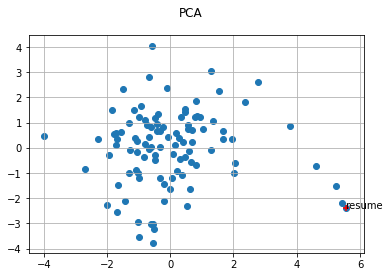

In [23]:
def plot_pca(data):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2) #, whiten=True
    X = pca.fit_transform(data)
    xs,ys =X[:,0], X[:,1]
    plt.scatter(X[:,0], X[:,1])
    plt.scatter(xs[-1], ys[-1], c='Red', marker='+')
    plt.text(xs[-1], ys[-1],'resume')
    plt.grid()
    plt.suptitle('PCA')
    #plt.savefig('distance_PCA_improved.png')
    plt.show()
plot_pca(data)

## Calculate the cosine distances between our resume and each of the job descriptions

In [24]:
from sklearn.metrics.pairwise import cosine_distances
cos_dist =[]
for i in range(len(data)):
    cos_dist.append(float(cosine_distances(resume_vect[0:].reshape(1,-1),data[i].reshape(1,-1))))

create a key words list for each job description

In [25]:
key_list =[]

for j in jd:
    key =''
    for word in keywords(j).split('\n'):
        key += '{} '.format(word)
    key_list.append(key)

Create a nice data frame to put the scores and keywords together. Print out the first 10 lowest scores. Those jobs will the most similar to the resume.

In [26]:
role = df['role'].tolist()
summary = pd.DataFrame({
        'Role Title': role,
        'Cosine Distances': cos_dist,
        'Keywords': key_list,
        'Job Description': jd
    })
z = summary.sort_values(by ='Cosine Distances', ascending=True)
z.head(10)

,Role Title,Cosine Distances,Keywords,Job Description
34,Data Scientist,0.411758,knowledge engineer experience learning data go...,- Data Scientist / Data Engineer - Chica...
35,Data Scientist,0.525758,knowledge experience scientist learning google,"Data Scientist Chicago, IL Contract &..."
98,Data Engineer,0.571648,computational high computing numerical methods...,Applied Computational Mathematician / Engineer...
20,Data Scientist,0.583079,experience data lead leading bdm time field di...,Big Data Lead Raritan- NJ -12 months ...
30,Data Scientist,0.641342,experience experiments data models model model...,"Data Scientist Richardson, TX Full T..."
76,Data Analyst,0.653861,solutions like perform alternative solution pr...,"Sr. Business Analyst UC Innovation - Irvine, C..."
0,Developer,0.662683,years developer development developing sql ser...,Artificial Intelligence / Machine Learning D...
13,Data Engineer,0.674135,data experience hive technical terms term cont...,Data Engineer Plano TX Terms Long Te...
23,Data Analyst,0.693346,data biomarker clinical patient good multivari...,Clinical Data Analyst ll 7+ months Contra...
15,Data Analyst,0.711819,data analytics analytical experience software ...,"Data Analytics Consultant Basking Ridge, N..."


Let's print the first job description and our resume text to visually compare.

In [27]:
z['Job Description'].iloc[0]

'   - Data Scientist / Data Engineer    - Chicago, IL    - Long Term  Exp Req  - 8+ Years        -      Senior data scientist / engineer      Financial Domain Knowledge & experience     Strong Experience in AI related      Knowledge & exposure in rendering ML functionality     Understanding  AI/Deep Learning algorithm such as CNN, RNN, LSTM     Experience in building AI based NLP and OCR solution using Keras, Google Tensorflow, Theano, Caffe 2 etc? '

In [28]:
r1

"Â\x95  with around 5 years of experience in all phases of diverse   specializing in Data Science, Big Data, Azure Machine Learning, Google Cloud and Tableau, using Cloud based infrastructure.   Â\x95 ed on analyzing large datasets on distributed databases and developing Machine Learning algorithms to gain operational insights and present them to the leadership.   Â\x95 Extensively ed on Data preparation, exploratory analysis, Feature engineering using supervised and unsupervised modeling.   Â\x95 Experienced the full software life cycle in SDLC, Agile and Scrum methodologies.   Â\x95 Expert in using of statistical  and programming languages (R, Python, C, C++, Java, SQL, UNIX)   Â\x95 Adapted statistical programming languages like R and Python   Â\x95 Well-versed with Linear/non-linear, regression and classification modeling predictive algorithms.   Â\x95 Actively involved in model selection, statistical analysis using SAS and Gretl statistical tool.   Â\x95 Created dashboards as part


Let's test it out on another resume or dataset.

In [29]:
df1 = pd.read_csv('https://raw.githubusercontent.com/JimKing100/techsearch/master/data/techsearch_p1.csv')
df1 = df1.drop(df1.columns[0], axis=1)
df2 = pd.read_csv('https://raw.githubusercontent.com/JimKing100/techsearch/master/data/techsearch_p2.csv')
df2 = df2.drop(df2.columns[0], axis=1)
both_df = pd.concat([df1, df2], ignore_index=True)

In [30]:
both_df.head()

,job_title,company,location,description,counts,city,job,low_salary,high_salary
0,Data Scientist (All Levels) - Santa Clara,LeanTaaS,"Santa Clara, CA 95050",Help build technology that saves lives!\n\nWe'...,1259,San Jose,data scientist,NaN,NaN
1,Data Scientist (Intern) - United States,Cisco Careers,"San Jose, CA","What You‚Äôll DoAcquire, clean and structure d...",1259,San Jose,data scientist,NaN,NaN
2,Data Scientist,Stanford University,"Stanford, CA",Data Scientist (Data Analyst 2)\nJob Family: I...,1259,San Jose,data scientist,NaN,NaN
3,"Data Scientist in Santa Clara, CA (corp-corp c...",Advantine Technologies,"Santa Clara, CA",Job Description\n\nTitle : Data Scientist\nLoc...,1259,San Jose,data scientist,NaN,NaN
4,Data Scientist,Palo Verde Consulting,"Campbell, CA 95008","Job Title: Data ScientistLocation: Campbell, C...",1259,San Jose,data scientist,150000.0,210000.0


If you feel like you've got it, go ahead apply the steps we used up above on the job descriptions in this new data.

In [31]:
both_df.shape

(7827, 9)